<a href="https://colab.research.google.com/github/jbrazonath/DL/blob/main/BRAZON_JOSMAR_DL_TP3_Co22_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de Buenos Aires
# Aprendizaje Profundo - TP3
# Cohorte 22 - 5to bimestre 2025


Este tercer y último TP se debe entregar hasta las **23hs del viernes 12 de diciembre (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP3 EQUIVALE A UN TERCIO DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/kscHDArwzdvrTSG99)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP3.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP3-Co22.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT/view?usp=sharing

Les recomiendo usar el siguiente código para poder obtener las imágenes fácilmente desde ese link. Pero son libres de descargar las imágenes como mejor les parezca.

In [21]:
import gdown
import zipfile
import os

url = "https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT"
output = "archivo.zip"

gdown.download(url, output, quiet=False)

destino = "datos_zip"
os.makedirs(destino, exist_ok=True)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

DATASET_ROOT_TRAIN = '/content/datos_zip/dataset_emociones/train'
DATASET_ROOT_VAL   = '/content/datos_zip/dataset_emociones/validation'


Downloading...
From (original): https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT
From (redirected): https://drive.google.com/uc?id=1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT&confirm=t&uuid=910f369f-bd9e-4741-8d7d-980ecb2df6a8
To: /content/archivo.zip
100%|██████████| 40.0M/40.0M [00:00<00:00, 71.7MB/s]


## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento. Lean su documentación si tienen dudas: https://docs.pytorch.org/vision/0.14/transforms.html



In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(
    root=str(DATASET_ROOT_TRAIN),
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=str(DATASET_ROOT_VAL),
    transform=val_transform
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("clases:", class_names)

train_counts = Counter([label for _, label in train_dataset])
print("cantidad de imágenes por clase (train):")
for idx, cls in enumerate(class_names):
    print(cls, ":", train_counts[idx])


clases: ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']
cantidad de imágenes por clase (train):
alegria : 4772
disgusto : 717
enojo : 705
miedo : 281
seriedad : 2524
sorpresa : 1290
tristeza : 1982


In [23]:
import torch
import numpy as np

# 1. Extraer los conteos en orden
conteos = list(train_counts.values())

# 2. Calcular pesos (Inverso de la frecuencia)
total_muestras = sum(conteos)
class_weights = [total_muestras / c for c in conteos]

# Convertir a Tensor
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Pesos calculados: {class_weights}")

Pesos calculados: [2.571458507963118, 17.11436541143654, 17.405673758865248, 43.669039145907476, 4.8617274167987325, 9.512403100775193, 6.191220988900101]


Dado el alto desbalance entre emociones (por ejemplo: alegría 4772 vs miedo 281), se aplicó una pérdida ponderada con pesos inversamente proporcionales a la frecuencia de cada clase. Esto evita que el modelo quede sesgado hacia la clase mayoritaria

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, número y tamaño de los kernels, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MiCNN(nn.Module):
    def __init__(self, num_classes):
        super(MiCNN, self).__init__()

        # BLOQUE 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # BLOQUE 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        # BLOQUE 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        # BLOQUE 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # 64x64 -> 4 pools -> 4x4, con 256 canales
        self.flatten_dim = 256 * 8 * 8

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 64 -> 32
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 32 -> 16
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 16 -> 8
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 8  -> 4

        # MUY IMPORTANTE: conservar el batch
        x = x.view(x.size(0), -1)  # (batch, 4096)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


num_clases = len(class_names)
model = MiCNN(num_classes=num_clases)
print(model)


MiCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)


## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


Epoch 1/20 - Train Loss: 1.9050, Val Loss: 1.7674 - Train Acc: 0.2147, Val Acc: 0.4068 - Train F1: 0.2374, Val F1: 0.3892
Nuevo mejor modelo guardado (Val F1 = 0.3892)
Epoch 2/20 - Train Loss: 1.8364, Val Loss: 1.7721 - Train Acc: 0.2531, Val Acc: 0.3902 - Train F1: 0.2781, Val F1: 0.3457
Epoch 3/20 - Train Loss: 1.7636, Val Loss: 1.6043 - Train Acc: 0.3318, Val Acc: 0.4505 - Train F1: 0.3514, Val F1: 0.4512
Nuevo mejor modelo guardado (Val F1 = 0.4512)
Epoch 4/20 - Train Loss: 1.7123, Val Loss: 1.4904 - Train Acc: 0.3583, Val Acc: 0.4899 - Train F1: 0.3818, Val F1: 0.4879
Nuevo mejor modelo guardado (Val F1 = 0.4879)
Epoch 5/20 - Train Loss: 1.6539, Val Loss: 1.4334 - Train Acc: 0.3687, Val Acc: 0.5215 - Train F1: 0.3991, Val F1: 0.5213
Nuevo mejor modelo guardado (Val F1 = 0.5213)
Epoch 6/20 - Train Loss: 1.6360, Val Loss: 1.5994 - Train Acc: 0.3877, Val Acc: 0.4257 - Train F1: 0.4110, Val F1: 0.4297
Epoch 7/20 - Train Loss: 1.5768, Val Loss: 1.2913 - Train Acc: 0.4033, Val Acc: 0.57

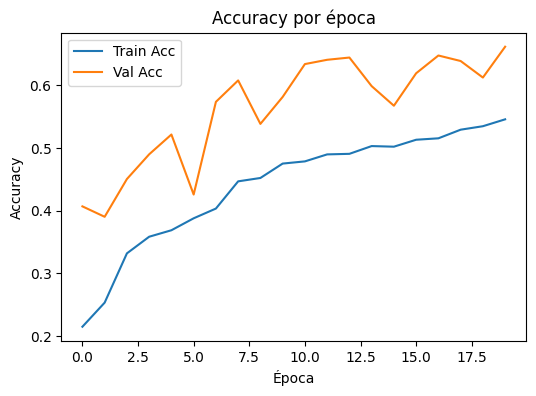

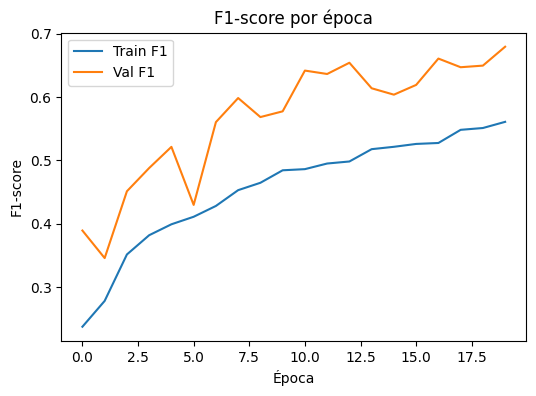

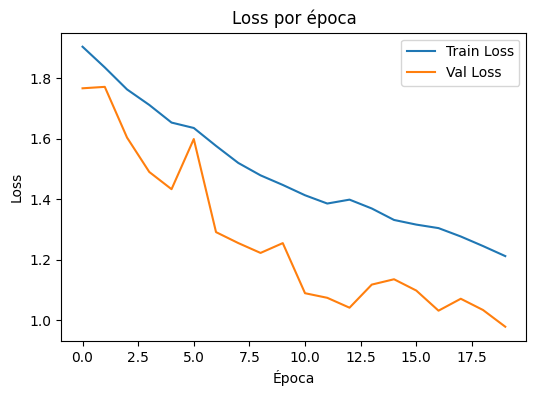


=== CLASSIFICATION REPORT (VALIDACIÓN, mejor modelo) ===
              precision    recall  f1-score   support

     alegria       0.92      0.78      0.85      1185
    disgusto       0.21      0.45      0.29       160
       enojo       0.60      0.70      0.65       162
       miedo       0.44      0.53      0.48        74
    seriedad       0.64      0.54      0.59       680
    sorpresa       0.79      0.77      0.78       329
    tristeza       0.46      0.54      0.50       478

    accuracy                           0.66      3068
   macro avg       0.58      0.62      0.59      3068
weighted avg       0.71      0.66      0.68      3068



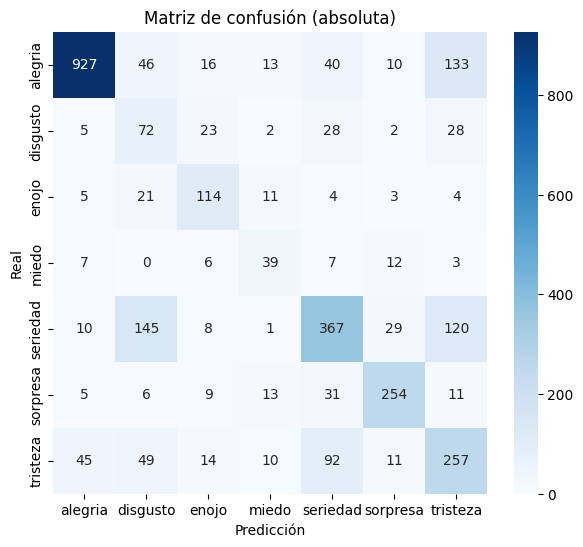

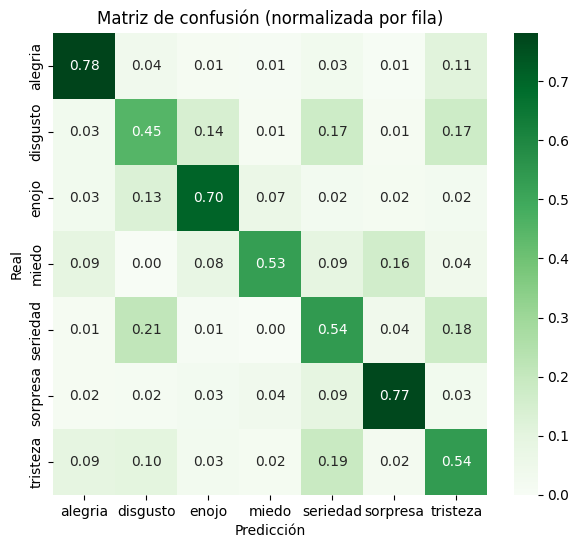

In [40]:
# ------------------------------------------------------------
# 0) IMPORTS Y SEMILLA
# ------------------------------------------------------------
import random
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------------------------------------------
# 1) DEVICE, MODELO, LOSS, OPTIMIZADOR, SCHEDULERS
# ------------------------------------------------------------
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

class_weights_tensor = class_weights_tensor.to(device)

model = MiCNN(num_classes=num_clases).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

warmup_epochs = 3

scheduler_warmup = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=0.2,
    total_iters=warmup_epochs
)

scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.1,
    patience=3
)

# ------------------------------------------------------------
# 2) HISTORIA DE MÉTRICAS + TRACKING DEL MEJOR MODELO
# ------------------------------------------------------------
train_loss_hist = []
val_loss_hist   = []
train_acc_hist  = []
val_acc_hist    = []
train_f1_hist   = []
val_f1_hist     = []

epochs = 20

best_val_f1 = -1.0
best_val_acc = 0.0
best_state_dict = None

# ------------------------------------------------------------
# 3) LOOP DE ENTRENAMIENTO
# ------------------------------------------------------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    train_preds  = []
    train_labels = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        preds = torch.argmax(outputs, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = np.mean(train_losses)
    train_acc  = accuracy_score(train_labels, train_preds)
    train_f1   = f1_score(train_labels, train_preds, average="weighted")

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1)

    # ------------------------- VALIDACIÓN -------------------------
    model.eval()
    val_losses = []
    val_preds  = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = np.mean(val_losses)
    val_acc  = accuracy_score(val_labels, val_preds)
    val_f1   = f1_score(val_labels, val_preds, average="weighted")

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} "
          f"- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} "
          f"- Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} "
          f"- Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    # schedulers
    if epoch < warmup_epochs:
        scheduler_warmup.step()
    else:
        scheduler_plateau.step(val_loss)

    # guardar mejor modelo según F1 de validación
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_acc = val_acc
        best_state_dict = model.state_dict().copy()
        print(f"Nuevo mejor modelo guardado (Val F1 = {best_val_f1:.4f})")

# ------------------------------------------------------------
# 4) RESTAURAR MEJOR MODELO Y REEVALUAR EN VALIDACIÓN
# ------------------------------------------------------------
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"\nModelo restaurado al mejor estado (Val F1 = {best_val_f1:.4f}, Val Acc = {best_val_acc:.4f})")

model.eval()
val_labels_best = []
val_preds_best  = []
val_losses_best = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_losses_best.append(loss.item())

        preds = torch.argmax(outputs, dim=1)
        val_preds_best.extend(preds.cpu().numpy())
        val_labels_best.extend(labels.cpu().numpy())

final_val_loss = np.mean(val_losses_best)
final_val_acc  = accuracy_score(val_labels_best, val_preds_best)
final_val_f1   = f1_score(val_labels_best, val_preds_best, average="weighted")

print(f"\nAccuracy final validación (mejor modelo): {final_val_acc:.4f}")
print(f"F1-score final validación (mejor modelo): {final_val_f1:.4f}")

# ------------------------------------------------------------
# 5) GRÁFICAS: ACCURACY, F1, LOSS
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Accuracy por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_f1_hist, label="Train F1")
plt.plot(val_f1_hist, label="Val F1")
plt.title("F1-score por época")
plt.xlabel("Época")
plt.ylabel("F1-score")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Loss por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 6) CLASSIFICATION REPORT Y MATRICES DE CONFUSIÓN
# ------------------------------------------------------------
print("\n=== CLASSIFICATION REPORT (VALIDACIÓN, mejor modelo) ===")
print(classification_report(val_labels_best, val_preds_best, target_names=class_names))

cm = confusion_matrix(val_labels_best, val_preds_best)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Matriz de confusión (absoluta)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

cm_norm = confusion_matrix(val_labels_best, val_preds_best, normalize="true")

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Greens")
plt.title("Matriz de confusión (normalizada por fila)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 10 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Debe haber al menos una imagen para cada emoción.

- Aplicar el mismo pre-procesamiento que se usó para el dataset de validation durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase (normalizado de 0 a 1 o de 0% a 100%)
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

In [41]:
# --- Clonar el repo en Colab (solo la 1ra vez) ---
!rm -rf DL   # elimina carpeta previa si existía
!git clone https://github.com/jbrazonath/DL.git


Cloning into 'DL'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 55 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 4.05 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (18/18), done.


Se encontraron 10 imágenes en test_images

Archivo: istockphoto-184649211-612x612.jpg
Scores por clase (0–100%):
  alegria   :  4.49%
  disgusto  : 22.50%
  enojo     : 23.60%
  miedo     :  9.07%
  seriedad  :  6.90%
  sorpresa  :  8.23%
  tristeza  : 25.21%

Clase predicha: tristeza


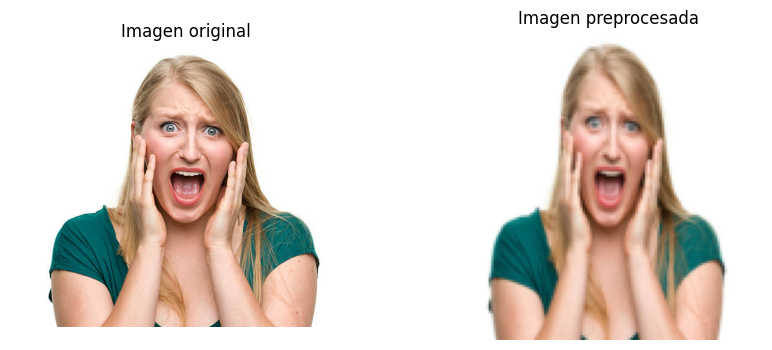


Archivo: cara-de-asco.jpg
Scores por clase (0–100%):
  alegria   :  2.44%
  disgusto  : 12.06%
  enojo     : 56.57%
  miedo     : 11.93%
  seriedad  :  2.33%
  sorpresa  :  7.93%
  tristeza  :  6.74%

Clase predicha: enojo


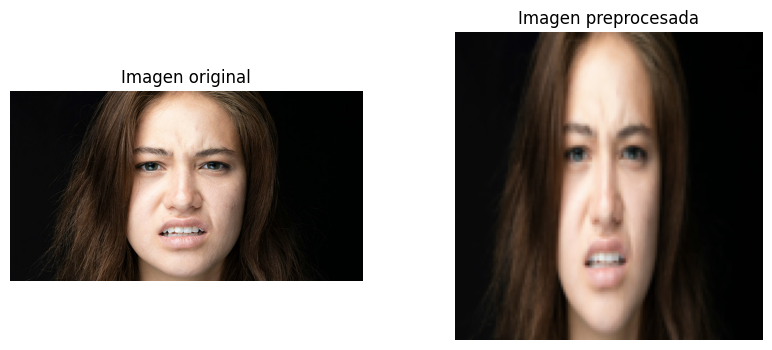


Archivo: depositphotos_2444604-stock-photo-very-sad-little-boy.jpg
Scores por clase (0–100%):
  alegria   :  6.72%
  disgusto  :  4.71%
  enojo     : 20.96%
  miedo     : 35.23%
  seriedad  :  2.12%
  sorpresa  : 14.87%
  tristeza  : 15.40%

Clase predicha: miedo


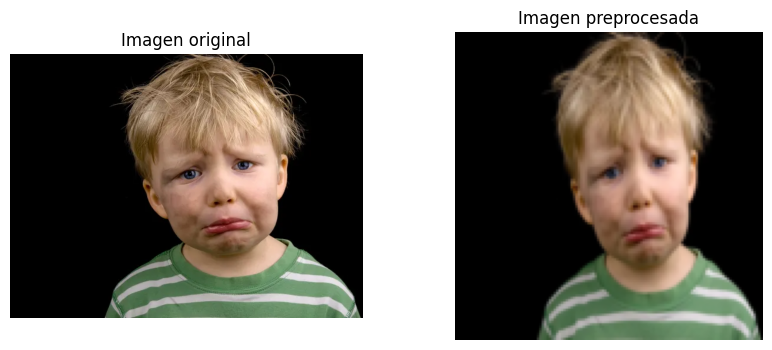


Archivo: WhatsApp Image 2025-12-08 at 12.59.03 PM.jpeg
Scores por clase (0–100%):
  alegria   :  4.59%
  disgusto  : 25.72%
  enojo     :  4.96%
  miedo     :  2.49%
  seriedad  : 23.98%
  sorpresa  :  3.82%
  tristeza  : 34.45%

Clase predicha: tristeza


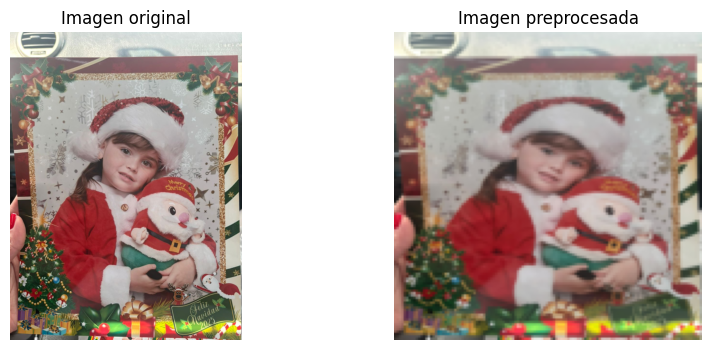


Archivo: istockphoto-1146642361-612x612.jpg
Scores por clase (0–100%):
  alegria   :  7.29%
  disgusto  : 12.81%
  enojo     :  7.51%
  miedo     :  7.73%
  seriedad  : 28.18%
  sorpresa  : 23.23%
  tristeza  : 13.24%

Clase predicha: seriedad


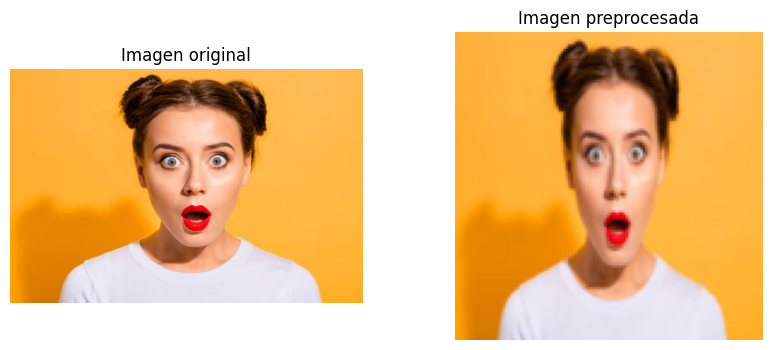


Archivo: photo-1624272949900-9ae4c56397e8.jpeg
Scores por clase (0–100%):
  alegria   :  6.46%
  disgusto  :  7.25%
  enojo     : 27.60%
  miedo     : 28.66%
  seriedad  :  2.03%
  sorpresa  :  9.91%
  tristeza  : 18.08%

Clase predicha: miedo


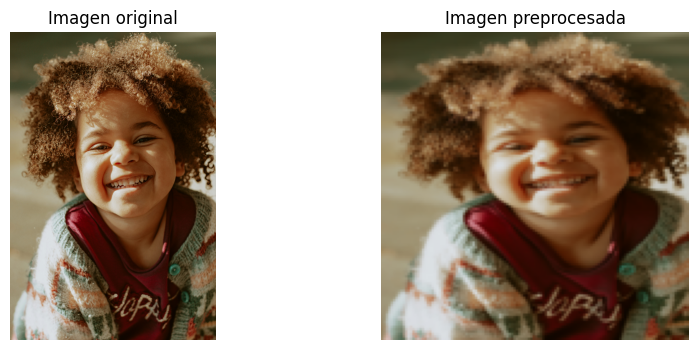


Archivo: premium_photo-1664536392779-049ba8fde933.jpeg
Scores por clase (0–100%):
  alegria   :  0.98%
  disgusto  :  1.84%
  enojo     : 57.98%
  miedo     : 29.57%
  seriedad  :  0.04%
  sorpresa  :  3.30%
  tristeza  :  6.28%

Clase predicha: enojo


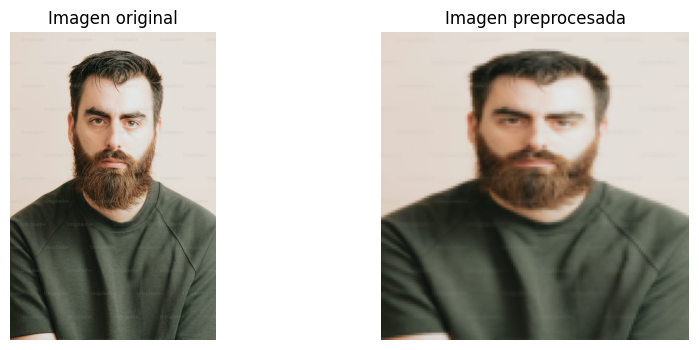


Archivo: WhatsApp Image 2025-11-30 at 3.19.08 PM.jpeg
Scores por clase (0–100%):
  alegria   :  9.29%
  disgusto  : 13.21%
  enojo     : 14.58%
  miedo     : 16.26%
  seriedad  :  8.20%
  sorpresa  : 13.23%
  tristeza  : 25.23%

Clase predicha: tristeza


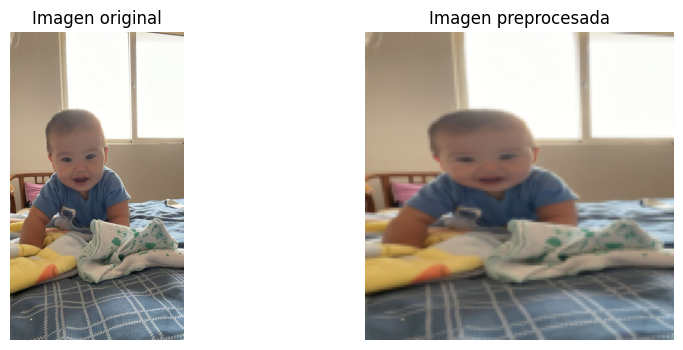


Archivo: 7cc1e589c13b255426ead5fb3a82c0c7.jpg
Scores por clase (0–100%):
  alegria   :  0.95%
  disgusto  : 47.46%
  enojo     : 33.32%
  miedo     :  1.22%
  seriedad  :  4.53%
  sorpresa  :  1.55%
  tristeza  : 10.98%

Clase predicha: disgusto


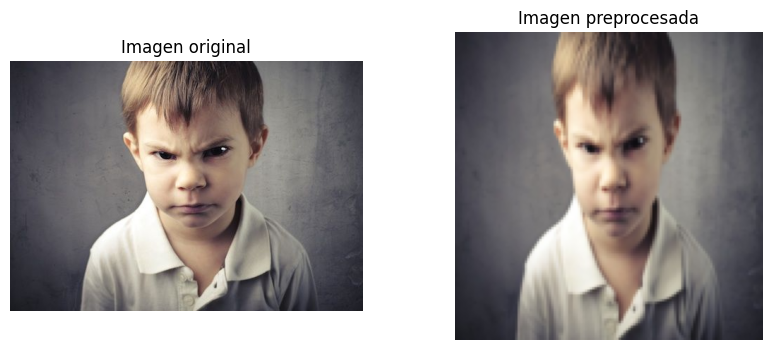


Archivo: WhatsApp Image 2025-12-08 at 11.59.53 AM.jpeg
Scores por clase (0–100%):
  alegria   :  6.36%
  disgusto  : 24.82%
  enojo     : 17.90%
  miedo     :  7.91%
  seriedad  : 12.72%
  sorpresa  :  7.61%
  tristeza  : 22.67%

Clase predicha: disgusto


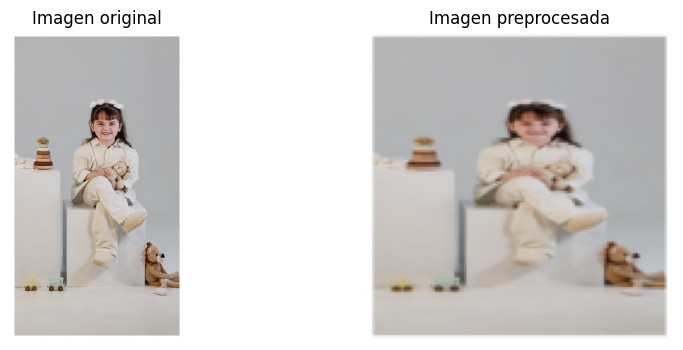

In [42]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

# ---------------------------
# MISMA TRANSFORM QUE VALIDACIÓN (RGB)
# ---------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),                    # mismo tamaño que en train/val
    transforms.ToTensor(),                         # [H,W,C] -> [C,H,W] en [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5],     # normalización simétrica
                         std=[0.5, 0.5, 0.5])
])

# carpeta con tus imágenes de prueba dentro del repo clonado
test_dir = "/content/DL/test_images"

# ---------------------------
# FUNCIÓN DE PREDICCIÓN
# ---------------------------
def predict_image(img_path):
    # 1) abrir y forzar RGB (por si alguna está en escala de grises)
    img = Image.open(img_path).convert("RGB")
    original_img = img.copy()

    # 2) aplicar las mismas transformaciones que en validación
    img_tensor = transform(img).unsqueeze(0).to(device)   # [1, 3, 64, 64]

    # 3) forward del modelo
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_idx = probs.argmax()
        pred_class = class_names[pred_idx]

    return original_img, img_tensor, probs, pred_class

# ---------------------------
# LISTAR ARCHIVOS EN test_images
# ---------------------------
image_files = [
    f for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
print(f"Se encontraron {len(image_files)} imágenes en test_images")

# ---------------------------
# PROCESAR Y MOSTRAR CADA IMAGEN
# ---------------------------
for filename in image_files:
    path = os.path.join(test_dir, filename)

    original, processed_tensor, probs, pred_class = predict_image(path)

    print("\n====================================")
    print(f"Archivo: {filename}")
    print("Scores por clase (0–100%):")
    for cls, p in zip(class_names, probs):
        print(f"  {cls:10s}: {p*100:5.2f}%")
    print(f"\nClase predicha: {pred_class}")

    # mostrar original y preprocesada
    plt.figure(figsize=(10, 4))

    # original
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Imagen original")
    plt.axis("off")

    # tensor -> numpy para visualizar
    proc_np = processed_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    # des-normalizar para que se vea bien (vuelve a 0–1)
    proc_np = (proc_np * 0.5) + 0.5
    proc_np = proc_np.clip(0, 1)

    plt.subplot(1, 2, 2)
    plt.imshow(proc_np)
    plt.title("Imagen preprocesada")
    plt.axis("off")

    plt.show()


 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 10 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase (normalizado de 0 a 1 o de 0% a 100%)
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código y modificar el `scaleFactor` y el `minNeighbors` según crean conveniente para obtener mejores resultados.

Se encontraron 10 imágenes en DL/test_images

Imagen: 7cc1e589c13b255426ead5fb3a82c0c7.jpg
Scores por clase (0–1):
  alegria   : 0.0009
  disgusto  : 0.2454
  enojo     : 0.7486
  miedo     : 0.0006
  seriedad  : 0.0010
  sorpresa  : 0.0004
  tristeza  : 0.0031

Clase predicha: enojo


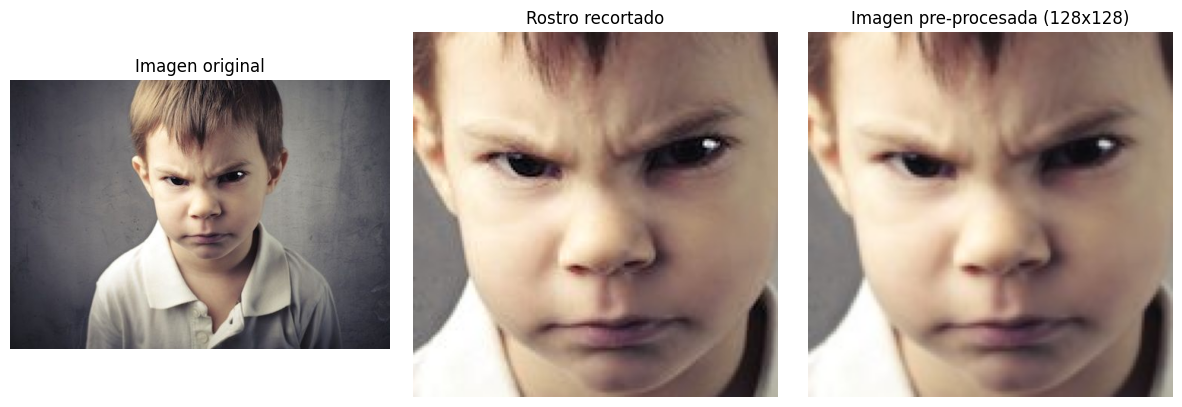


Imagen: WhatsApp Image 2025-11-30 at 3.19.08 PM.jpeg
Scores por clase (0–1):
  alegria   : 0.1444
  disgusto  : 0.1147
  enojo     : 0.0397
  miedo     : 0.0727
  seriedad  : 0.2471
  sorpresa  : 0.1191
  tristeza  : 0.2623

Clase predicha: tristeza


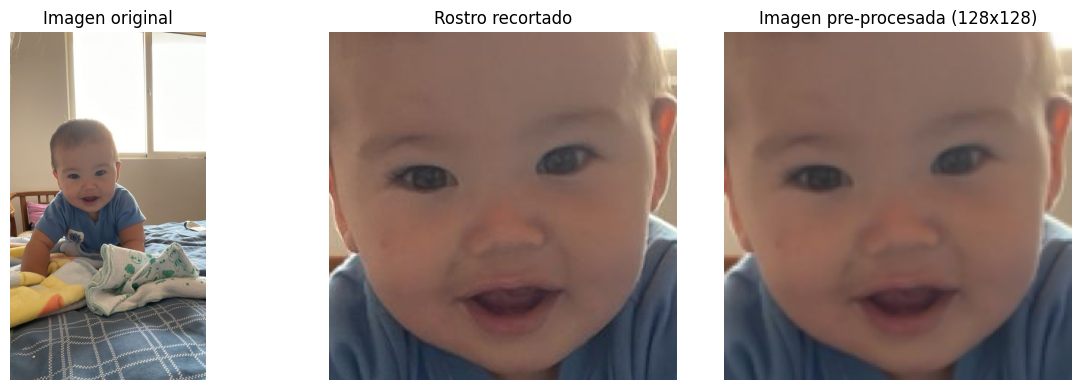


Imagen: WhatsApp Image 2025-12-08 at 11.59.53 AM.jpeg
Scores por clase (0–1):
  alegria   : 0.0094
  disgusto  : 0.1391
  enojo     : 0.7915
  miedo     : 0.0229
  seriedad  : 0.0026
  sorpresa  : 0.0076
  tristeza  : 0.0268

Clase predicha: enojo


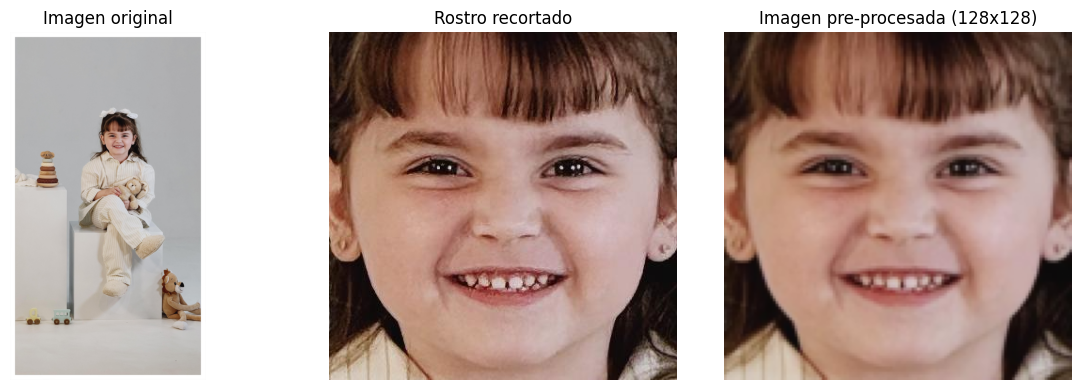


Imagen: WhatsApp Image 2025-12-08 at 12.59.03 PM.jpeg
Scores por clase (0–1):
  alegria   : 0.0459
  disgusto  : 0.2572
  enojo     : 0.0496
  miedo     : 0.0249
  seriedad  : 0.2398
  sorpresa  : 0.0382
  tristeza  : 0.3445

Clase predicha: tristeza


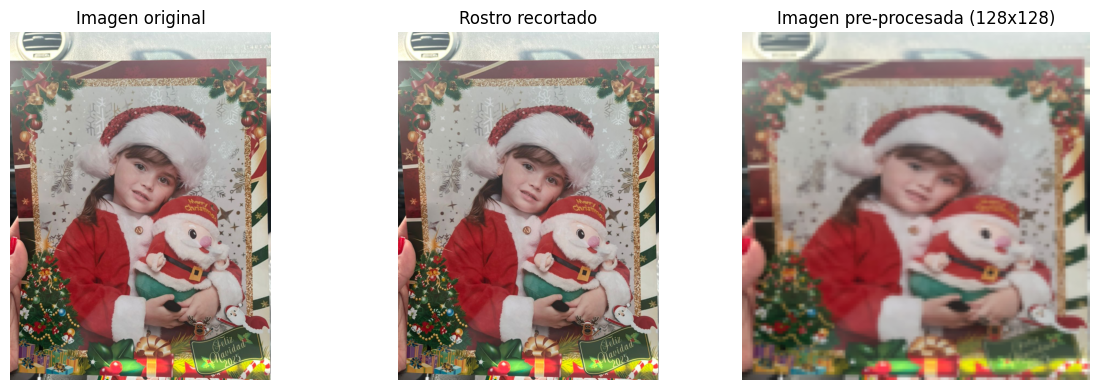


Imagen: cara-de-asco.jpg
Scores por clase (0–1):
  alegria   : 0.0392
  disgusto  : 0.4237
  enojo     : 0.1825
  miedo     : 0.0244
  seriedad  : 0.0974
  sorpresa  : 0.0177
  tristeza  : 0.2152

Clase predicha: disgusto


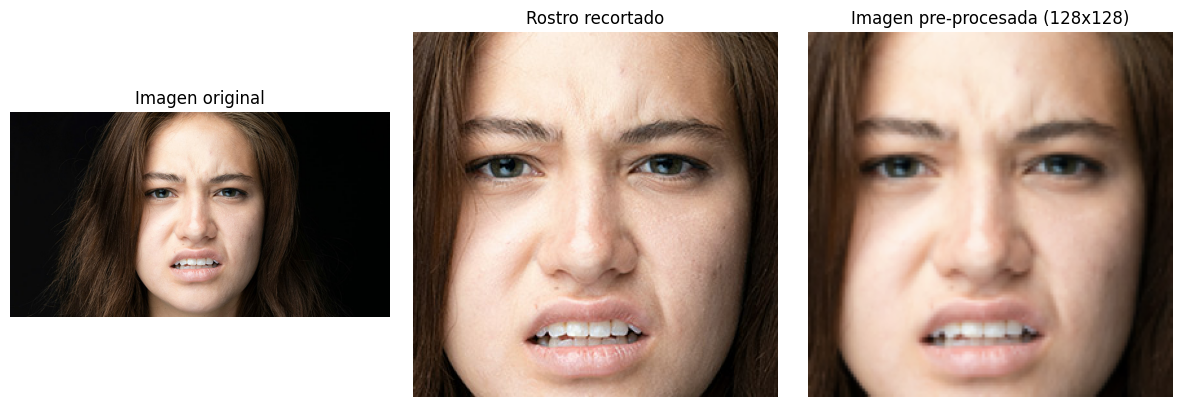


Imagen: depositphotos_2444604-stock-photo-very-sad-little-boy.jpg
Scores por clase (0–1):
  alegria   : 0.0716
  disgusto  : 0.1964
  enojo     : 0.0220
  miedo     : 0.0177
  seriedad  : 0.2434
  sorpresa  : 0.0207
  tristeza  : 0.4282

Clase predicha: tristeza


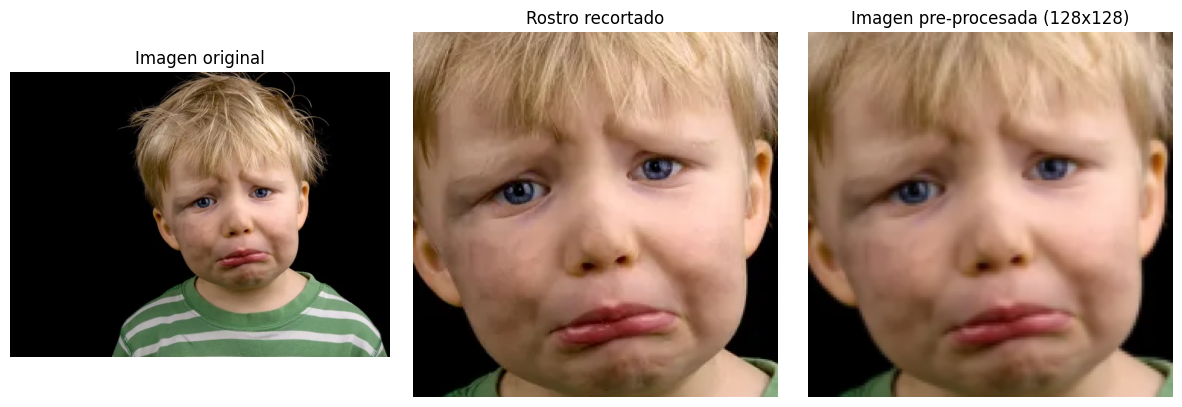


Imagen: istockphoto-1146642361-612x612.jpg
Scores por clase (0–1):
  alegria   : 0.0307
  disgusto  : 0.0314
  enojo     : 0.0628
  miedo     : 0.0728
  seriedad  : 0.1638
  sorpresa  : 0.6180
  tristeza  : 0.0204

Clase predicha: sorpresa


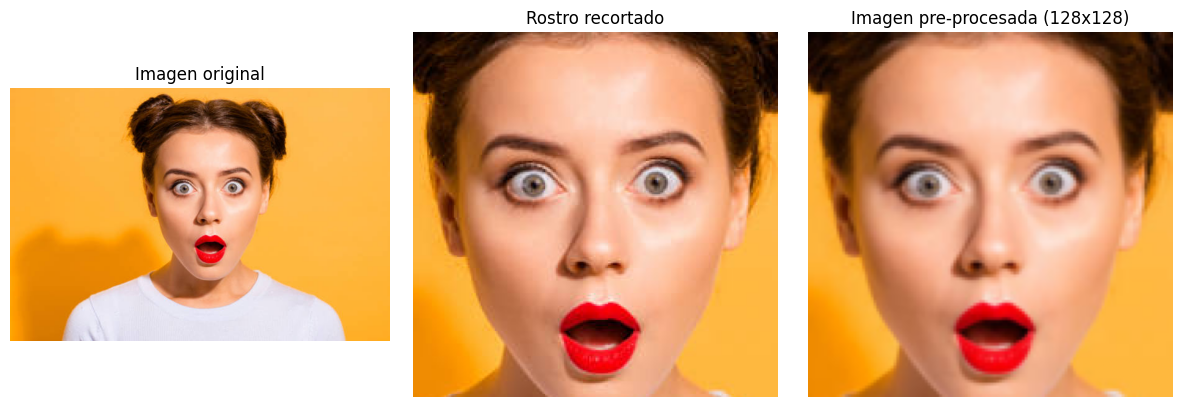


Imagen: istockphoto-184649211-612x612.jpg
Scores por clase (0–1):
  alegria   : 0.3372
  disgusto  : 0.0964
  enojo     : 0.0790
  miedo     : 0.1365
  seriedad  : 0.0499
  sorpresa  : 0.0422
  tristeza  : 0.2588

Clase predicha: alegria


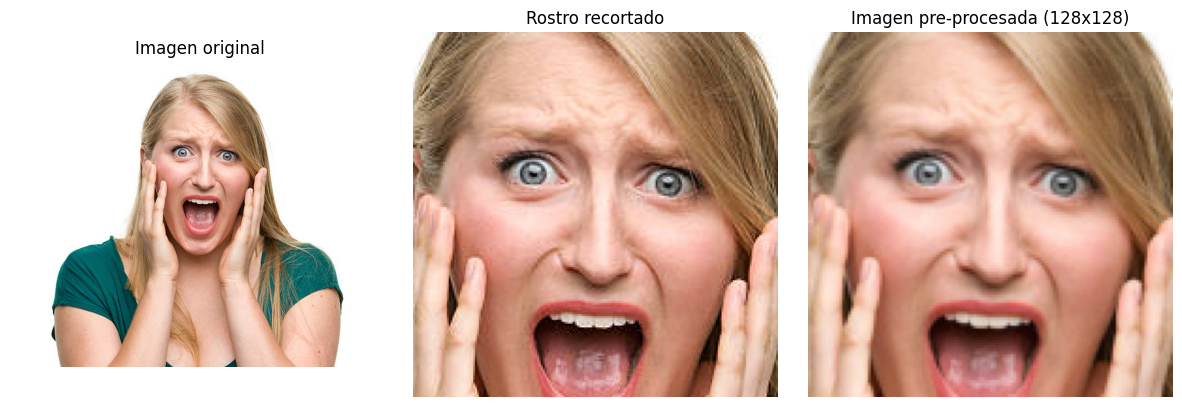


Imagen: photo-1624272949900-9ae4c56397e8.jpeg
Scores por clase (0–1):
  alegria   : 0.8052
  disgusto  : 0.0261
  enojo     : 0.0169
  miedo     : 0.0395
  seriedad  : 0.0089
  sorpresa  : 0.0050
  tristeza  : 0.0982

Clase predicha: alegria


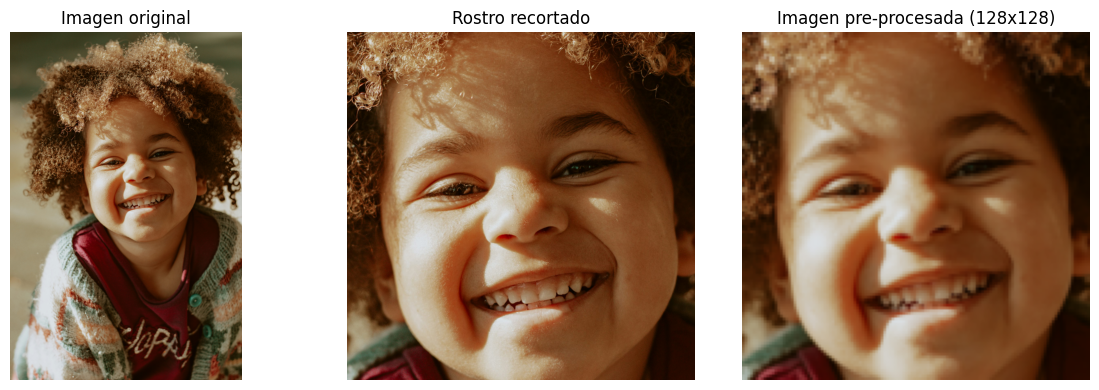


Imagen: premium_photo-1664536392779-049ba8fde933.jpeg
Scores por clase (0–1):
  alegria   : 0.0241
  disgusto  : 0.2972
  enojo     : 0.4994
  miedo     : 0.0307
  seriedad  : 0.0518
  sorpresa  : 0.0503
  tristeza  : 0.0465

Clase predicha: enojo


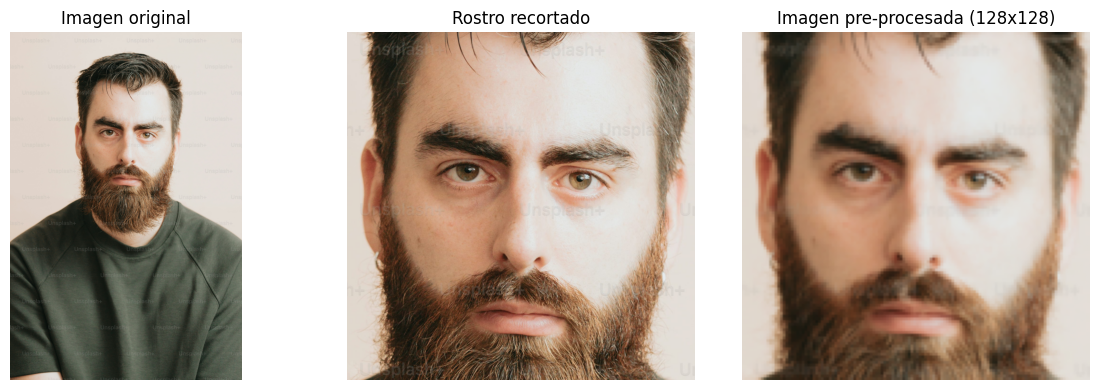

In [43]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

# Carpeta con las 10 imágenes nuevas
test_dir = "DL/test_images"

# Clasificador de rostros de OpenCV
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

model.eval()  # muy importante para evaluación


def detect_crop_and_predict(img_path):
    """
    - Lee la imagen
    - Detecta rostro y recorta (1:1)
    - Aplica val_transform
    - Corre el modelo y devuelve todo lo necesario
    """
    # 1) Leer imagen en BGR (formato OpenCV)
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise ValueError(f"No se pudo leer la imagen: {img_path}")

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # 2) Detección de rostro
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=6
    )

    cropped_face_rgb = None

    if len(faces) > 0:
        # por si detecta varias, nos quedamos con la más grande
        faces_sorted = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)
        (x, y, w, h) = faces_sorted[0]

        # hacemos el recorte cuadrado centrado en el rostro
        center_x, center_y = x + w // 2, y + h // 2
        side = max(w, h)
        half_side = side // 2

        x1 = max(center_x - half_side, 0)
        y1 = max(center_y - half_side, 0)
        x2 = min(center_x + half_side, bgr.shape[1])
        y2 = min(center_y + half_side, bgr.shape[0])

        cropped = bgr[y1:y2, x1:x2]
        cropped_face_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    else:
        # si no detecta rostro, usamos la imagen completa
        cropped_face_rgb = rgb

    # 3) Pre-procesamiento (mismas transformaciones de validación)
    pil_cropped = Image.fromarray(cropped_face_rgb)
    img_tensor = val_transform(pil_cropped).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    pred_idx = int(np.argmax(probs))
    pred_class = class_names[pred_idx]

    # 4) Imagen pre-procesada para mostrar (des-normalizada)
    img_for_show = img_tensor[0].cpu().clone()
    # val_transform tiene Normalize(mean=[0.5]*3, std=[0.5]*3)
    img_for_show = img_for_show * 0.5 + 0.5
    img_for_show = img_for_show.clamp(0, 1)
    img_preproc = np.transpose(img_for_show.numpy(), (1, 2, 0))

    return rgb, cropped_face_rgb, img_preproc, probs, pred_class


# ------------------------------------------------------------------
# Loop sobre las 10 imágenes y visualización
# ------------------------------------------------------------------
image_files = [
    f for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
image_files = sorted(image_files)[:10]

print(f"Se encontraron {len(image_files)} imágenes en {test_dir}")

for filename in image_files:
    path = os.path.join(test_dir, filename)

    original_rgb, cropped_rgb, preproc_rgb, probs, pred_class = \
        detect_crop_and_predict(path)

    print("\n====================================")
    print(f"Imagen: {filename}")
    print("Scores por clase (0–1):")
    for cls, p in zip(class_names, probs):
        print(f"  {cls:10s}: {p:.4f}")
    print(f"\nClase predicha: {pred_class}")

    # 3 imágenes: original, recortada, pre-procesada
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_rgb)
    axes[0].set_title("Imagen original")
    axes[0].axis("off")

    axes[1].imshow(cropped_rgb)
    axes[1].set_title("Rostro recortado")
    axes[1].axis("off")

    axes[2].imshow(preproc_rgb)
    axes[2].set_title("Imagen pre-procesada (128x128)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
